# Deep convolutional generative adversarial network (GAN)
#### for generating MNIST-like images of handwritten digits


Before we start we need to load libraries and setup the model hyperparameters

In [107]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 128 
# learning rate is how fast it will descend
model_args['lr'] = 2.e-4
# the number of epochs is the number of times you go through the full dataset 
model_args['epochs'] = 50
# GAN parameters:
model_args['latent_space_dim'] = 100

Let's start with loading the dataset and definig dataloaders

In [98]:
# load the MINST dataset via torchvision 
transform = transforms.ToTensor()
train_subset = datasets.MNIST('../data', train=True, download=True, transform=transform)

In [108]:
# load the FashionMINST dataset via torchvision 
transform = transforms.ToTensor()
train_subset = datasets.FashionMNIST('../data', train=True, download=True, transform=transform)

In [109]:
# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)

Plot sample images

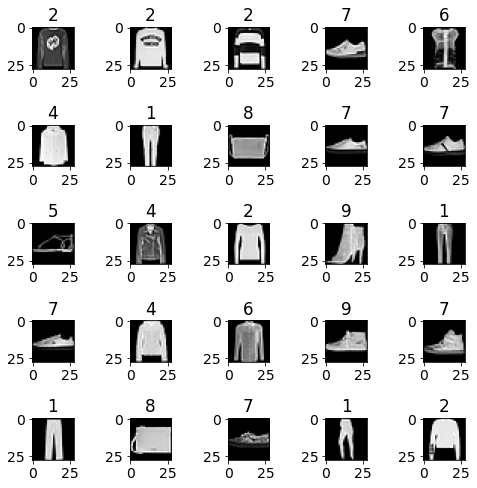

In [110]:
example_number = 123
fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(train_subset[example_number+i*5+j][0].reshape(28,28), cmap='gray')
        axs[i,j].set_title(train_subset[example_number+i*5+j][1])

Let's now construct a GAN model:
- we are using **nn.Sequential** to define the generator and discriminator models,
- generator utilizes *2D transposed convolutions* to size up feature maps in decoder.

LeakyReLU:

In [101]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Reshape(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)

class GAN(nn.Module):
    # this defines the generator and discriminator structures
    def __init__(self, latent_space_dim):
        super(GAN, self).__init__()
        self.latent_space_dim = latent_space_dim
        
        self.generator = nn.Sequential(
              
            nn.Linear(self.latent_space_dim, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            Flatten(),

            nn.Linear(7*7*32, 1),
            #nn.Sigmoid()
        )

    def generator_forward(self, z):
        return self.generator(z)
    
    def discriminator_forward(self, img):
        return self.discriminator(img).view(-1)


standard ReLU:

In [81]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Reshape(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)

class GAN(nn.Module):
    # this defines the generator and discriminator structures
    def __init__(self, latent_space_dim):
        super(GAN, self).__init__()
        self.latent_space_dim = latent_space_dim
        
        self.generator = nn.Sequential(
              
            nn.Linear(self.latent_space_dim, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.ReLU(inplace=True),
            Reshape(),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(inplace=True),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(inplace=True), 
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True), 
            #nn.Dropout2d(p=0.2),
            
            Flatten(),

            nn.Linear(7*7*32, 1),
            #nn.Sigmoid()
        )

    def generator_forward(self, z):
        return self.generator(z)
    
    def discriminator_forward(self, img):
        return self.discriminator(img).view(-1)


And define training and plotting utils:

In [102]:
def train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number):
    model.train()
    gen_losses = []
    dis_losses = []
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, _) in enumerate(train_loader):
        # normalize images to [-1, 1] range
        data = data*2. - 1.
        batch_size = data.size(0)
        # send data tensors to GPU (or CPU)
        data = data.to(device)
        # labels for training discriminator
        valid = torch.ones(batch_size).float().to(device)
        fake = torch.zeros(batch_size).float().to(device)
        # --------------------------
        # Train Generator
        # --------------------------
        # this will zero out the gradients for this batch
        optimizer_gen.zero_grad()
        # generate new images from noise
        z = torch.zeros((batch_size, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
        generated_images = model.generator_forward(z)   
        # loss for fooling the discriminator
        dis_predictions = model.discriminator_forward(generated_images.view(batch_size, 1, 28, 28))
        #
        gen_loss = F.binary_cross_entropy_with_logits(dis_predictions, valid) # not fooling D increases G loss
        gen_loss.backward()
        optimizer_gen.step()
        gen_losses.append(gen_loss.item())
        # --------------------------
        # Train Discriminator
        # --------------------------        
        # this will zero out the gradients for this batch
        optimizer_dis.zero_grad()
        # D predictions for real images
        dis_predictions_real = model.discriminator_forward(data.view(batch_size, 1, 28, 28))
        real_loss = F.binary_cross_entropy_with_logits(dis_predictions_real, valid) # D should classify real as valid
        # D predictions for generated images
        dis_predictions_fake = model.discriminator_forward(generated_images.view(batch_size, 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy_with_logits(dis_predictions_fake, fake) # D should classify generated as fake
        # 
        dis_loss = 0.5*(real_loss + fake_loss)
        dis_loss.backward()
        optimizer_dis.step()        
        dis_losses.append(dis_loss.item())

    return gen_losses, dis_losses


def plot_loss(gen_loss, dis_loss, title=None):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('loss')
    xlabels = np.linspace(0, model_args['epochs'], num=len(gen_loss), endpoint=True)
    plt.plot(xlabels, gen_loss, label='generator')
    plt.plot(xlabels, dis_loss, label='discriminator')
    plt.legend()
    if title is not None: plt.title(title)
    plt.show()

## Experiments

Let's define and plot the model

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GAN(model_args['latent_space_dim']).to(device)
print(model)

optimizer_gen = torch.optim.Adam(model.generator.parameters(), lr=model_args['lr'])
optimizer_dis = torch.optim.Adam(model.discriminator.parameters(), lr=model_args['lr'])

GAN(
  (generator): Sequential(
    (0): Linear(in_features=300, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2d(8, 1

In [104]:
from torchsummary import summary
model = model.to(device)
summary(model.generator, input_size=(100,))
summary(model.discriminator, input_size=(1, 28, 28))

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            940,800
├─BatchNorm1d: 1-2                       6,272
├─LeakyReLU: 1-3                         --
├─Reshape: 1-4                           --
├─ConvTranspose2d: 1-5                   18,432
├─BatchNorm2d: 1-6                       64
├─LeakyReLU: 1-7                         --
├─ConvTranspose2d: 1-8                   4,608
├─BatchNorm2d: 1-9                       32
├─LeakyReLU: 1-10                        --
├─ConvTranspose2d: 1-11                  1,152
├─BatchNorm2d: 1-12                      16
├─LeakyReLU: 1-13                        --
├─ConvTranspose2d: 1-14                  32
├─Tanh: 1-15                             --
Total params: 971,408
Trainable params: 971,408
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            72
├─BatchNorm2d: 1-2                       16
├─LeakyReLU: 1-3                         --
├─Conv2d: 1-4       

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            72
├─BatchNorm2d: 1-2                       16
├─LeakyReLU: 1-3                         --
├─Conv2d: 1-4                            2,304
├─BatchNorm2d: 1-5                       64
├─LeakyReLU: 1-6                         --
├─Flatten: 1-7                           --
├─Linear: 1-8                            1,569
Total params: 4,025
Trainable params: 4,025
Non-trainable params: 0

Then train the model

Task 1

In [ ]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Task 2

Latent space: 10

Train Epoch 1 | Generator loss = 0.8513 | Discriminator loss = 0.5936
Train Epoch 2 | Generator loss = 0.8334 | Discriminator loss = 0.6102
Train Epoch 3 | Generator loss = 0.8723 | Discriminator loss = 0.5774
Train Epoch 4 | Generator loss = 0.8351 | Discriminator loss = 0.6125
Train Epoch 5 | Generator loss = 0.8023 | Discriminator loss = 0.6365
Train Epoch 6 | Generator loss = 0.7755 | Discriminator loss = 0.6540
Train Epoch 7 | Generator loss = 0.7651 | Discriminator loss = 0.6628
Train Epoch 8 | Generator loss = 0.7543 | Discriminator loss = 0.6713
Train Epoch 9 | Generator loss = 0.7544 | Discriminator loss = 0.6741
Train Epoch 10 | Generator loss = 0.7405 | Discriminator loss = 0.6822
Train Epoch 11 | Generator loss = 0.7322 | Discriminator loss = 0.6892
Train Epoch 12 | Generator loss = 0.7231 | Discriminator loss = 0.6945
Train Epoch 13 | Generator loss = 0.7179 | Discriminator loss = 0.6968
Train Epoch 14 | Generator loss = 0.7158 | Discriminator loss = 0.6959
Train Epoch 15 

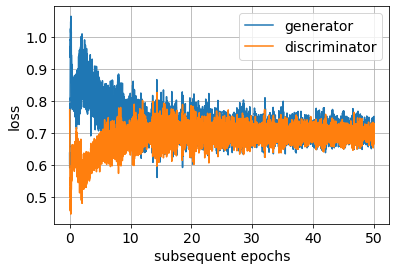

In [27]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Latent space: 50

Train Epoch 1 | Generator loss = 1.4217 | Discriminator loss = 0.3133
Train Epoch 2 | Generator loss = 1.1549 | Discriminator loss = 0.4330
Train Epoch 3 | Generator loss = 1.1755 | Discriminator loss = 0.4286
Train Epoch 4 | Generator loss = 1.2083 | Discriminator loss = 0.4361
Train Epoch 5 | Generator loss = 1.1108 | Discriminator loss = 0.4994
Train Epoch 6 | Generator loss = 1.1070 | Discriminator loss = 0.5005
Train Epoch 7 | Generator loss = 1.0543 | Discriminator loss = 0.5319
Train Epoch 8 | Generator loss = 1.0104 | Discriminator loss = 0.5558
Train Epoch 9 | Generator loss = 0.9935 | Discriminator loss = 0.5627
Train Epoch 10 | Generator loss = 0.9755 | Discriminator loss = 0.5783
Train Epoch 11 | Generator loss = 0.9465 | Discriminator loss = 0.5927
Train Epoch 12 | Generator loss = 0.9206 | Discriminator loss = 0.6081
Train Epoch 13 | Generator loss = 0.9032 | Discriminator loss = 0.6154
Train Epoch 14 | Generator loss = 0.8908 | Discriminator loss = 0.6231
Train Epoch 15 

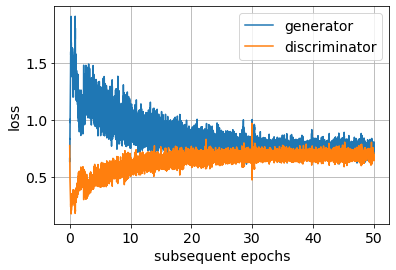

In [75]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Latent space: 100 (and Task 1)

Train Epoch 1 | Generator loss = 1.5032 | Discriminator loss = 0.3192
Train Epoch 2 | Generator loss = 1.0919 | Discriminator loss = 0.4653
Train Epoch 3 | Generator loss = 1.1019 | Discriminator loss = 0.4678
Train Epoch 4 | Generator loss = 1.1651 | Discriminator loss = 0.4526
Train Epoch 5 | Generator loss = 1.1016 | Discriminator loss = 0.4979
Train Epoch 6 | Generator loss = 1.0921 | Discriminator loss = 0.5123
Train Epoch 7 | Generator loss = 1.0627 | Discriminator loss = 0.5247
Train Epoch 8 | Generator loss = 1.0347 | Discriminator loss = 0.5453
Train Epoch 9 | Generator loss = 1.0084 | Discriminator loss = 0.5571
Train Epoch 10 | Generator loss = 0.9959 | Discriminator loss = 0.5738
Train Epoch 11 | Generator loss = 0.9458 | Discriminator loss = 0.6029
Train Epoch 12 | Generator loss = 0.9184 | Discriminator loss = 0.6152
Train Epoch 13 | Generator loss = 0.9171 | Discriminator loss = 0.6151
Train Epoch 14 | Generator loss = 0.8962 | Discriminator loss = 0.6290
Train Epoch 15 

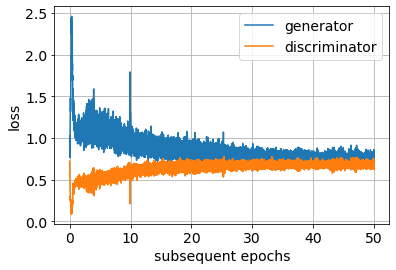

In [55]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Latent space: 200

Train Epoch 1 | Generator loss = 1.3451 | Discriminator loss = 0.3620
Train Epoch 2 | Generator loss = 1.0413 | Discriminator loss = 0.4918
Train Epoch 3 | Generator loss = 1.1085 | Discriminator loss = 0.4597
Train Epoch 4 | Generator loss = 1.1955 | Discriminator loss = 0.4355
Train Epoch 5 | Generator loss = 1.1553 | Discriminator loss = 0.4793
Train Epoch 6 | Generator loss = 1.1074 | Discriminator loss = 0.5082
Train Epoch 7 | Generator loss = 1.0597 | Discriminator loss = 0.5327
Train Epoch 8 | Generator loss = 1.0286 | Discriminator loss = 0.5505
Train Epoch 9 | Generator loss = 0.9932 | Discriminator loss = 0.5749
Train Epoch 10 | Generator loss = 0.9474 | Discriminator loss = 0.6002
Train Epoch 11 | Generator loss = 0.9324 | Discriminator loss = 0.6103
Train Epoch 12 | Generator loss = 0.9127 | Discriminator loss = 0.6167
Train Epoch 13 | Generator loss = 0.9032 | Discriminator loss = 0.6251
Train Epoch 14 | Generator loss = 0.8761 | Discriminator loss = 0.6364
Train Epoch 15 

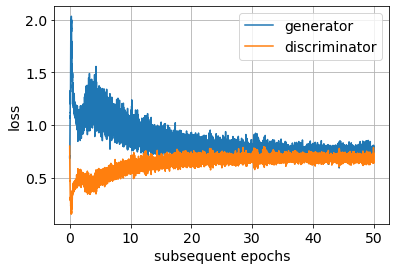

In [65]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Latent space: 300

Train Epoch 1 | Generator loss = 1.6341 | Discriminator loss = 0.2502
Train Epoch 2 | Generator loss = 1.1765 | Discriminator loss = 0.4383
Train Epoch 3 | Generator loss = 1.1986 | Discriminator loss = 0.4186
Train Epoch 4 | Generator loss = 1.3081 | Discriminator loss = 0.3893
Train Epoch 5 | Generator loss = 1.3118 | Discriminator loss = 0.3995
Train Epoch 6 | Generator loss = 1.3096 | Discriminator loss = 0.4105
Train Epoch 7 | Generator loss = 1.3074 | Discriminator loss = 0.4259
Train Epoch 8 | Generator loss = 1.2507 | Discriminator loss = 0.4514
Train Epoch 9 | Generator loss = 1.2127 | Discriminator loss = 0.4708
Train Epoch 10 | Generator loss = 1.1730 | Discriminator loss = 0.4932
Train Epoch 11 | Generator loss = 1.1421 | Discriminator loss = 0.5099
Train Epoch 12 | Generator loss = 1.1146 | Discriminator loss = 0.5239
Train Epoch 13 | Generator loss = 1.0731 | Discriminator loss = 0.5459
Train Epoch 14 | Generator loss = 1.0534 | Discriminator loss = 0.5565
Train Epoch 15 

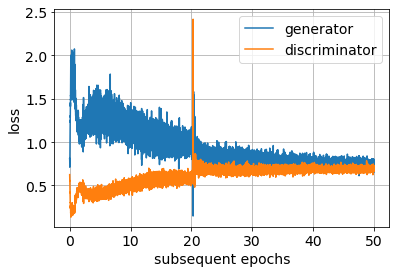

In [105]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Task 3

Train Epoch 1 | Generator loss = 1.3529 | Discriminator loss = 0.3391
Train Epoch 2 | Generator loss = 1.1227 | Discriminator loss = 0.4504
Train Epoch 3 | Generator loss = 1.2252 | Discriminator loss = 0.4055
Train Epoch 4 | Generator loss = 1.2403 | Discriminator loss = 0.4108
Train Epoch 5 | Generator loss = 1.1879 | Discriminator loss = 0.4532
Train Epoch 6 | Generator loss = 1.1135 | Discriminator loss = 0.5036
Train Epoch 7 | Generator loss = 1.0196 | Discriminator loss = 0.5569
Train Epoch 8 | Generator loss = 0.9566 | Discriminator loss = 0.5922
Train Epoch 9 | Generator loss = 0.9121 | Discriminator loss = 0.6177
Train Epoch 10 | Generator loss = 0.8722 | Discriminator loss = 0.6353
Train Epoch 11 | Generator loss = 0.8425 | Discriminator loss = 0.6517
Train Epoch 12 | Generator loss = 0.8335 | Discriminator loss = 0.6542
Train Epoch 13 | Generator loss = 0.8122 | Discriminator loss = 0.6666
Train Epoch 14 | Generator loss = 0.8050 | Discriminator loss = 0.6669
Train Epoch 15 

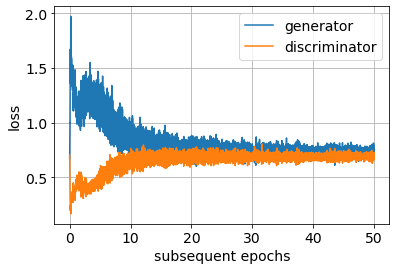

In [85]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Task 4

Train Epoch 1 | Generator loss = 1.5577 | Discriminator loss = 0.2874
Train Epoch 2 | Generator loss = 2.2260 | Discriminator loss = 0.1803
Train Epoch 3 | Generator loss = 1.5460 | Discriminator loss = 0.3143
Train Epoch 4 | Generator loss = 1.7423 | Discriminator loss = 0.2753
Train Epoch 5 | Generator loss = 1.6906 | Discriminator loss = 0.3087
Train Epoch 6 | Generator loss = 1.4759 | Discriminator loss = 0.3700
Train Epoch 7 | Generator loss = 1.3334 | Discriminator loss = 0.4291
Train Epoch 8 | Generator loss = 1.3485 | Discriminator loss = 0.4280
Train Epoch 9 | Generator loss = 1.3262 | Discriminator loss = 0.4332
Train Epoch 10 | Generator loss = 1.2397 | Discriminator loss = 0.4782
Train Epoch 11 | Generator loss = 1.1519 | Discriminator loss = 0.5107
Train Epoch 12 | Generator loss = 1.1680 | Discriminator loss = 0.5138
Train Epoch 13 | Generator loss = 1.0912 | Discriminator loss = 0.5522
Train Epoch 14 | Generator loss = 1.0671 | Discriminator loss = 0.5616
Train Epoch 15 

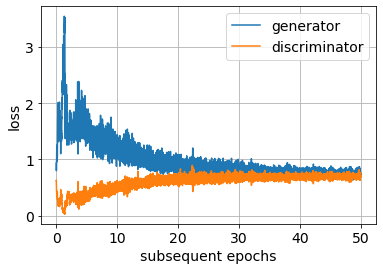

In [95]:
torch.manual_seed(model_args['seed'])
generator_loss = []
discriminator_loss = []
for epoch_number in range(1, model_args['epochs'] + 1):
    gen_losses, dis_losses = train(model, device, train_loader, optimizer_gen, optimizer_dis, epoch_number)
    print('Train Epoch {} | Generator loss = {:.4f} | Discriminator loss = {:.4f}'.format(
        epoch_number, np.mean(gen_losses), np.mean(dis_losses)))
    generator_loss.extend(gen_losses)
    discriminator_loss.extend(dis_losses)

plot_loss(generator_loss, discriminator_loss)

Generate images

Task 1

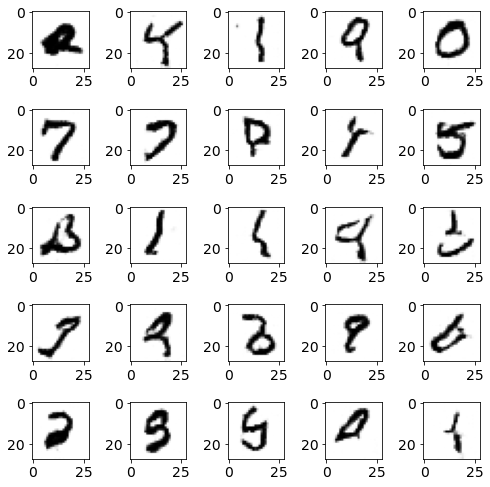

In [11]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

Task 2

Latent space: 10

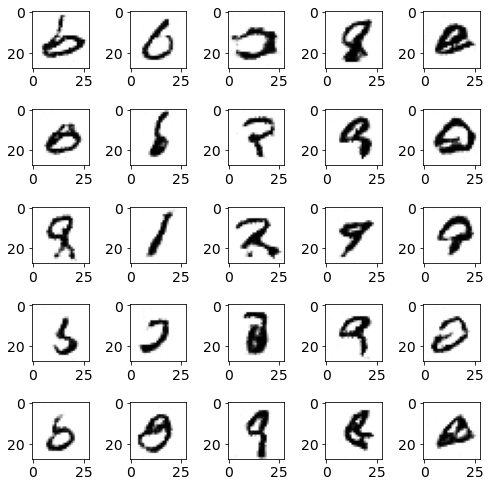

In [28]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

Latent space: 50

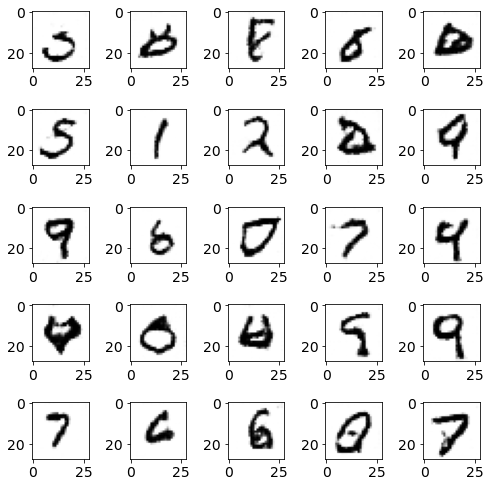

In [76]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

Latent space: 100 (and Task 1)

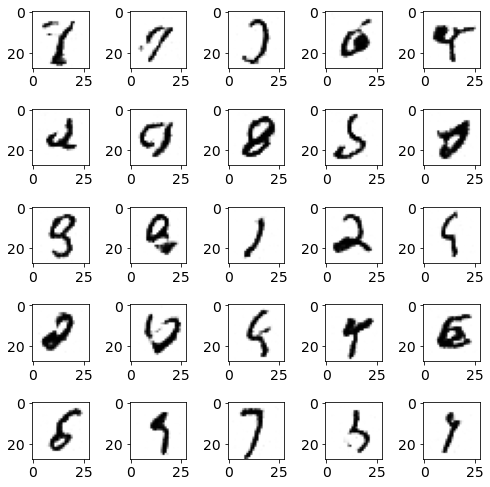

In [56]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

Latent space: 200

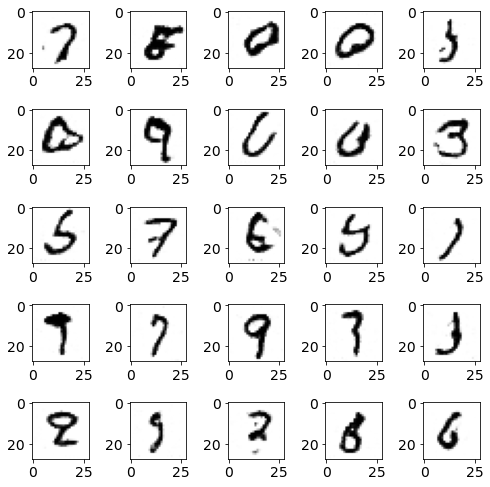

In [66]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

Latent space: 300

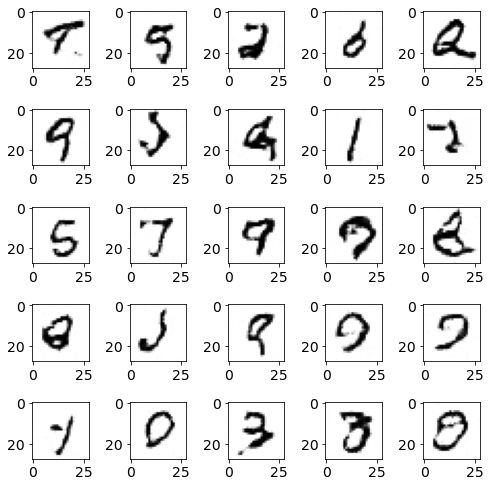

In [106]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

Task 3

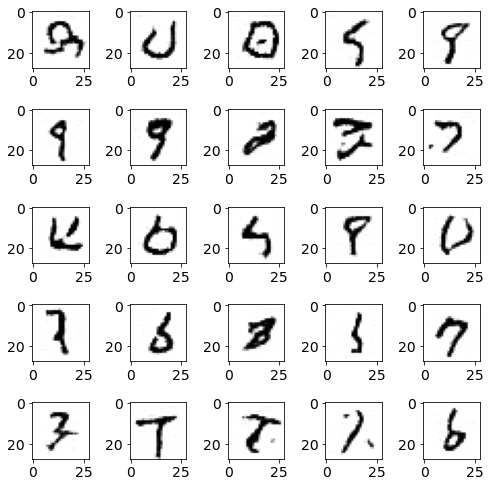

In [86]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

Task 4

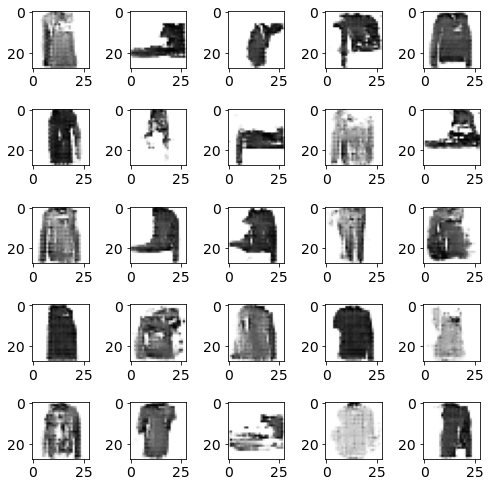

In [96]:
model.eval()

z = torch.zeros((25, model_args['latent_space_dim'])).uniform_(-1.0, 1.0).to(device)
generated_images = model.generator_forward(z)
imgs = generated_images.view(-1, 28, 28)


fig, axs = plt.subplots(5, 5, figsize=(7,7), tight_layout=True)
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(imgs[i*5+j].to(torch.device('cpu')).detach(), cmap='binary')

## Tasks to do
* run the code, train GAN model and generate your own MNIST images
* what if we increase/decrease the latent space size
* what if we change the LeakyReLU units into standard ReLU
* try the same with Fashion MNIST or other MNIST-like datasets, or with CIFAR (needs to change some input/output layers)